# Neural Spline Flow

In [62]:
# Import required packages
import torch
import numpy as np
import normflows as nf
from torchviz import make_dot
from sklearn.datasets import make_moons
from scipy.special import erf, gamma
from matplotlib import pyplot as plt
import benchmark
from tqdm import tqdm

In [80]:
# Set up model
target = benchmark.Gauss(1000)
# Define flows
K = 2
torch.manual_seed(0)

latent_size = 2
hidden_units = 4
num_blocks = 2
masks = nf.utils.iflow_binary_masks(latent_size)
for mask in masks[::-1]:
    print(mask)
# mask = nf.utils.masks.create_alternating_binary_mask(latent_size, even=True)
# print(mask)




# flows = []
# #for i in range(K):
# #     flows += [nf.flows.CoupledRationalQuadraticSpline(latent_size, num_blocks, hidden_units)]
# #     flows += [nf.flows.LULinearPermute(latent_size)]
# #flows += [nf.flows.CoupledRationalQuadraticSpline(latent_size, num_blocks, hidden_units)]
# #flows += [nf.flows.CoupledRationalQuadraticSpline(latent_size, num_blocks, hidden_units, reverse_mask=True)]
# for mask in masks[::-1]:
#     flows += [nf.flows.CoupledRationalQuadraticSpline(latent_size, num_blocks, hidden_units, mask=mask)]
# # Set base distribuiton
# q0 = nf.distributions.base.Uniform(2, 0.0, 1.0)
    
# # Construct flow model
# nfm = nf.NormalizingFlow(q0, flows, target)

# # Move model on GPU if available
# enable_cuda = True
# device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
# nfm = nfm.to(device)

tensor([0, 1], dtype=torch.uint8)
tensor([1, 0], dtype=torch.uint8)


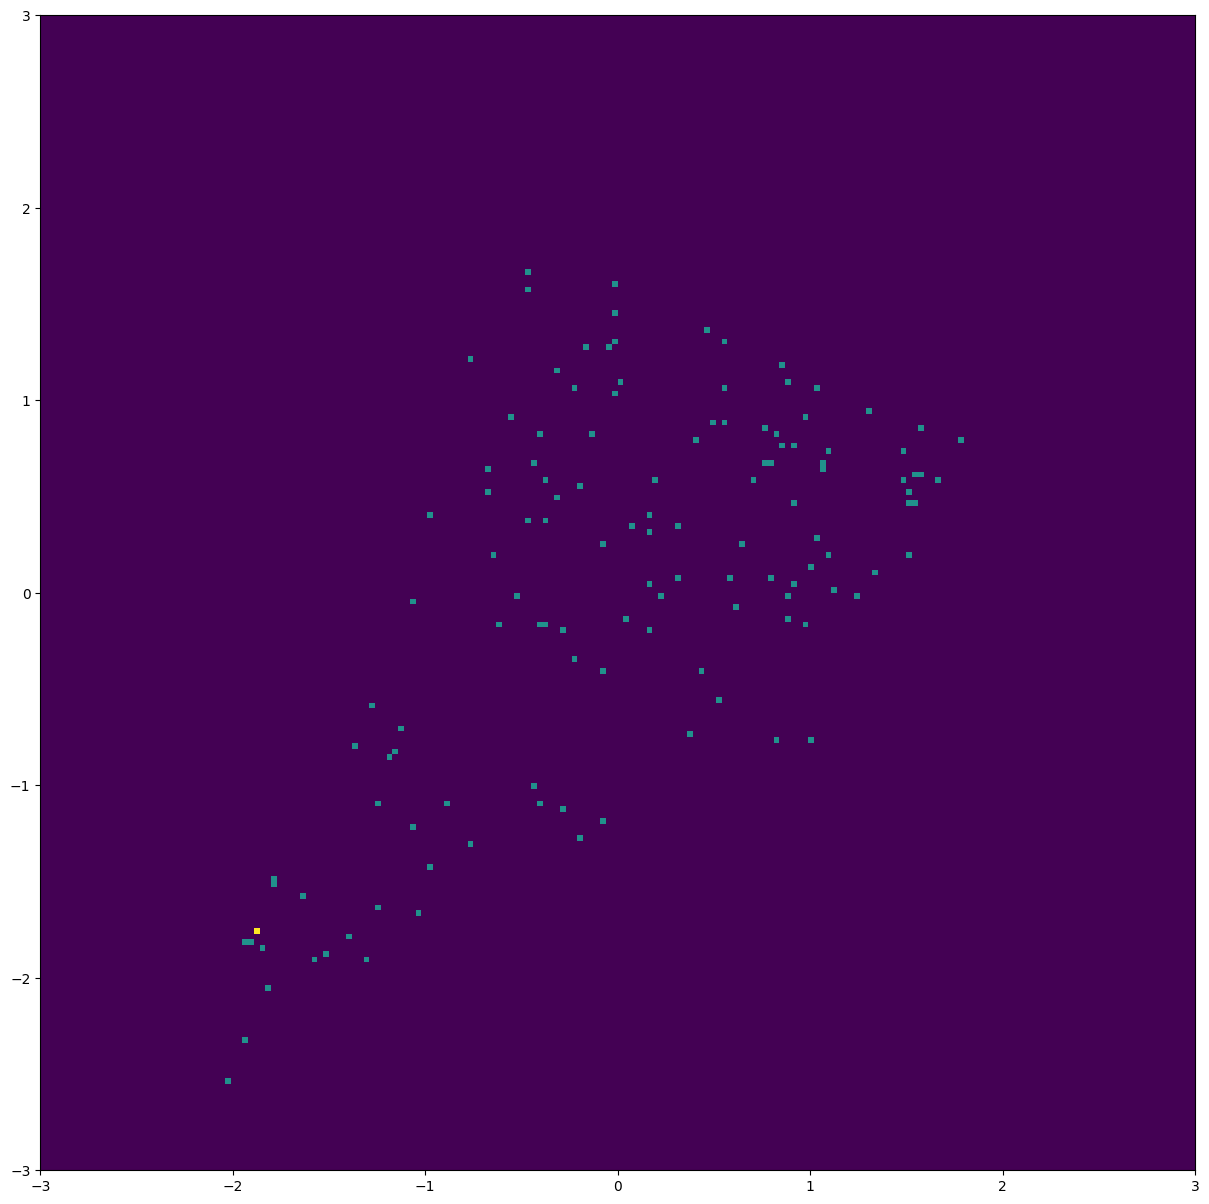

In [87]:
K = 4
torch.manual_seed(0)

latent_size = 2
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(K):
    #s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    #t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True)
    s = nf.nets.ResidualNet(2,2,16)
    t = nf.nets.ResidualNet(2,2,16)
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]

# Set target and q0
#target = nf.distributions.TwoModes(2, 0.1)
q0 = nf.distributions.base.Uniform(2, 0.0, 1.0)

# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)
nfm = nfm.double()

#Initialize ActNorm
z, _ = nfm.sample(num_samples=2 ** 7)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(15, 15))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (200, 200), range=[[-3, 3], [-3, 3]])
plt.gca().set_aspect('equal', 'box')
plt.show()

In [88]:
print(sum(p.numel() for p in nfm.parameters() if p.requires_grad))

9376


tensor([[2.9656e-05, 3.8078e-05, 4.8643e-05,  ..., 4.8643e-05, 3.8078e-05,
         2.9656e-05],
        [3.8078e-05, 4.8892e-05, 6.2457e-05,  ..., 6.2457e-05, 4.8892e-05,
         3.8078e-05],
        [4.8643e-05, 6.2457e-05, 7.9786e-05,  ..., 7.9786e-05, 6.2457e-05,
         4.8643e-05],
        ...,
        [4.8643e-05, 6.2457e-05, 7.9786e-05,  ..., 7.9786e-05, 6.2457e-05,
         4.8643e-05],
        [3.8078e-05, 4.8892e-05, 6.2457e-05,  ..., 6.2457e-05, 4.8892e-05,
         3.8078e-05],
        [2.9656e-05, 3.8078e-05, 4.8643e-05,  ..., 4.8643e-05, 3.8078e-05,
         2.9656e-05]])
tensor([[-10.4259, -10.1759,  -9.9310,  ...,  -9.9310, -10.1759, -10.4259],
        [-10.1759,  -9.9259,  -9.6810,  ...,  -9.6810,  -9.9259, -10.1759],
        [ -9.9310,  -9.6810,  -9.4362,  ...,  -9.4362,  -9.6810,  -9.9310],
        ...,
        [ -9.9310,  -9.6810,  -9.4362,  ...,  -9.4362,  -9.6810,  -9.9310],
        [-10.1759,  -9.9259,  -9.6810,  ...,  -9.6810,  -9.9259, -10.1759],
        [-1

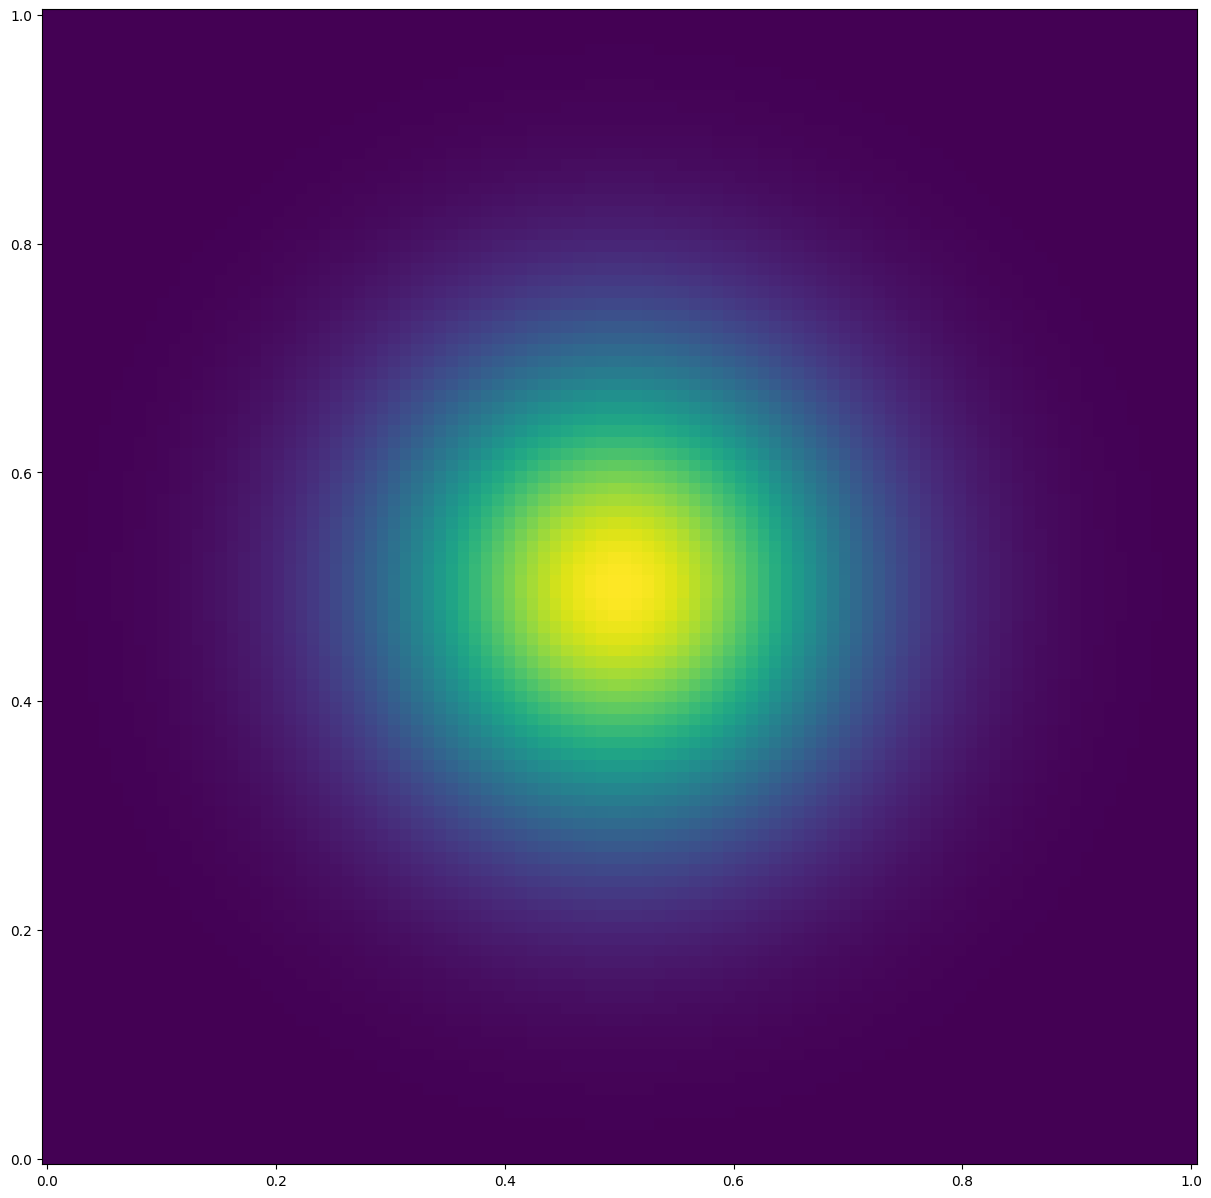

In [89]:
# Plot target distribution
# x_np, _ = make_moons(2 ** 20, noise=0.1)
# plt.figure(figsize=(15, 15))
# plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200)
# plt.show()

# Plot initial flow distribution
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(0.0, 1.0, grid_size), torch.linspace(0.0, 1.0, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

nfm.eval()
log_prob = nfm.p.log_prob(zz).to('cpu').view(*xx.shape)
prob = nfm.p.prob(zz).to('cpu').view(*xx.shape)
#prob = nfm.p.prob(zz).to('cpu').view(*xx.shape)
#print(prob, log_prob)
log_q = nfm.log_prob(zz).to('cpu').view(*xx.shape)
print(prob)
#log_prob = log_prob - log_q
print(log_prob,log_q)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

  2%|▊                                        | 99/5000 [00:03<02:29, 32.80it/s]

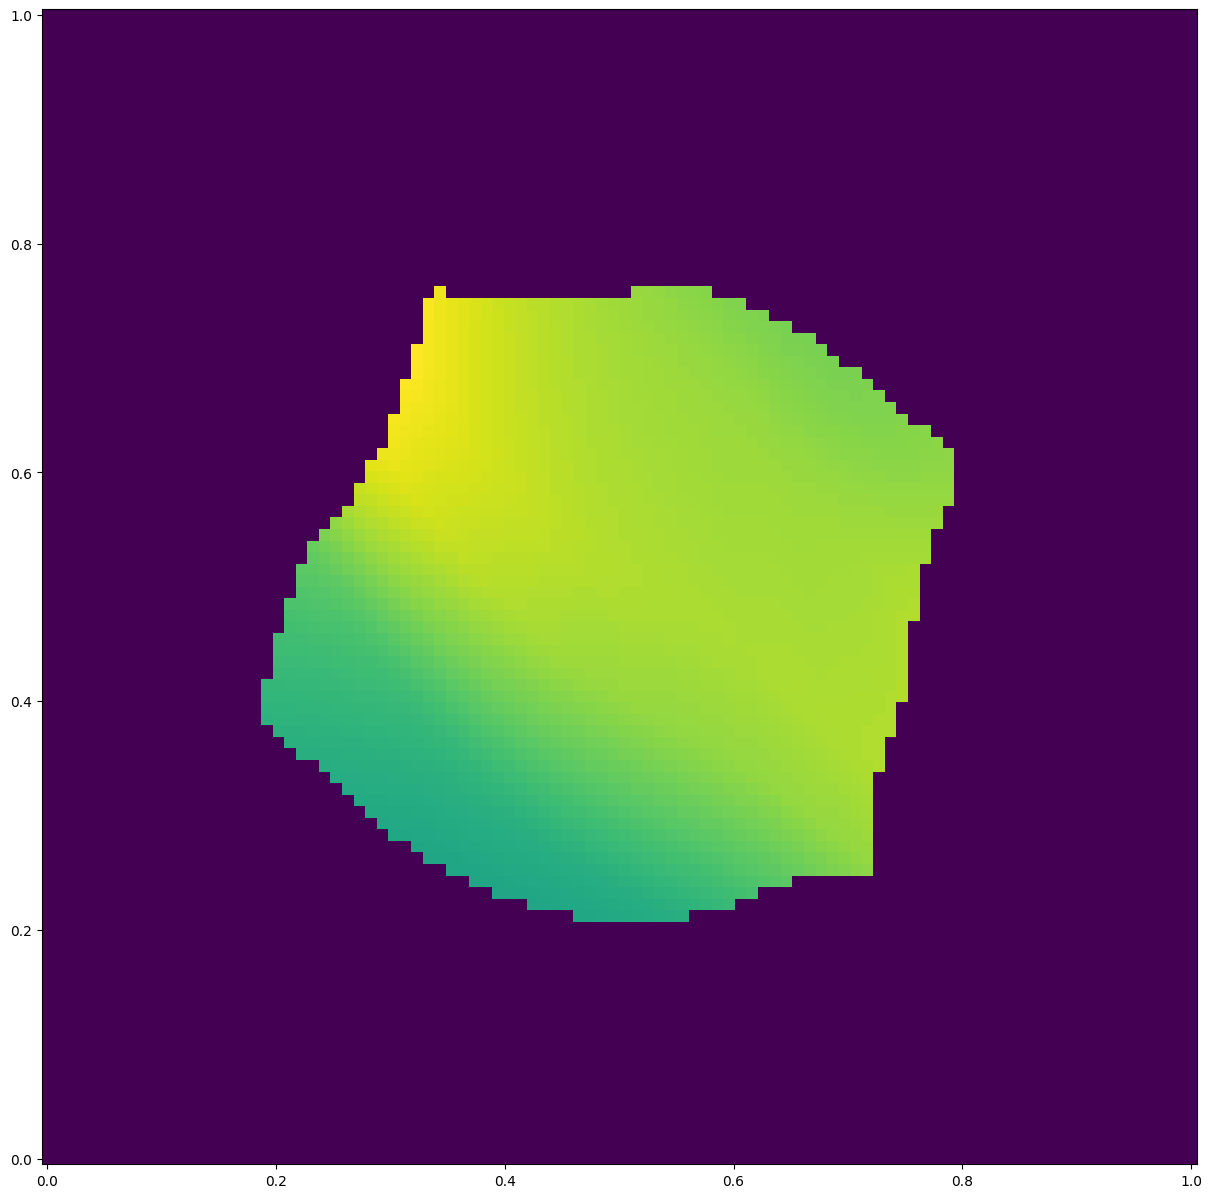

  4%|█▌                                      | 196/5000 [00:06<02:13, 35.92it/s]

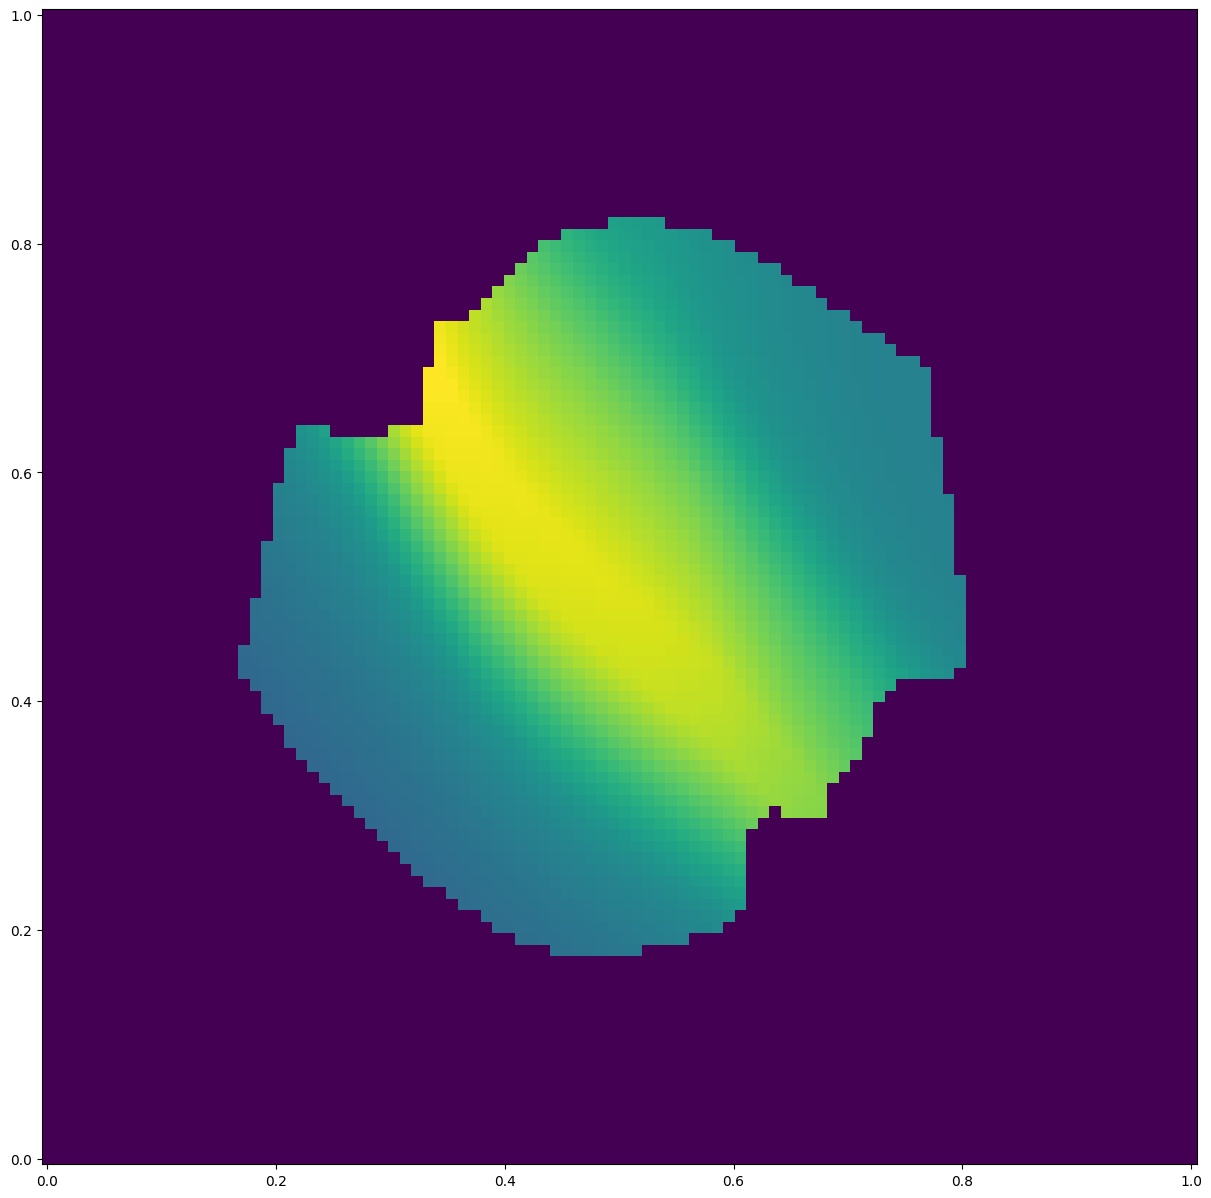

  6%|██▍                                     | 298/5000 [00:10<02:19, 33.80it/s]

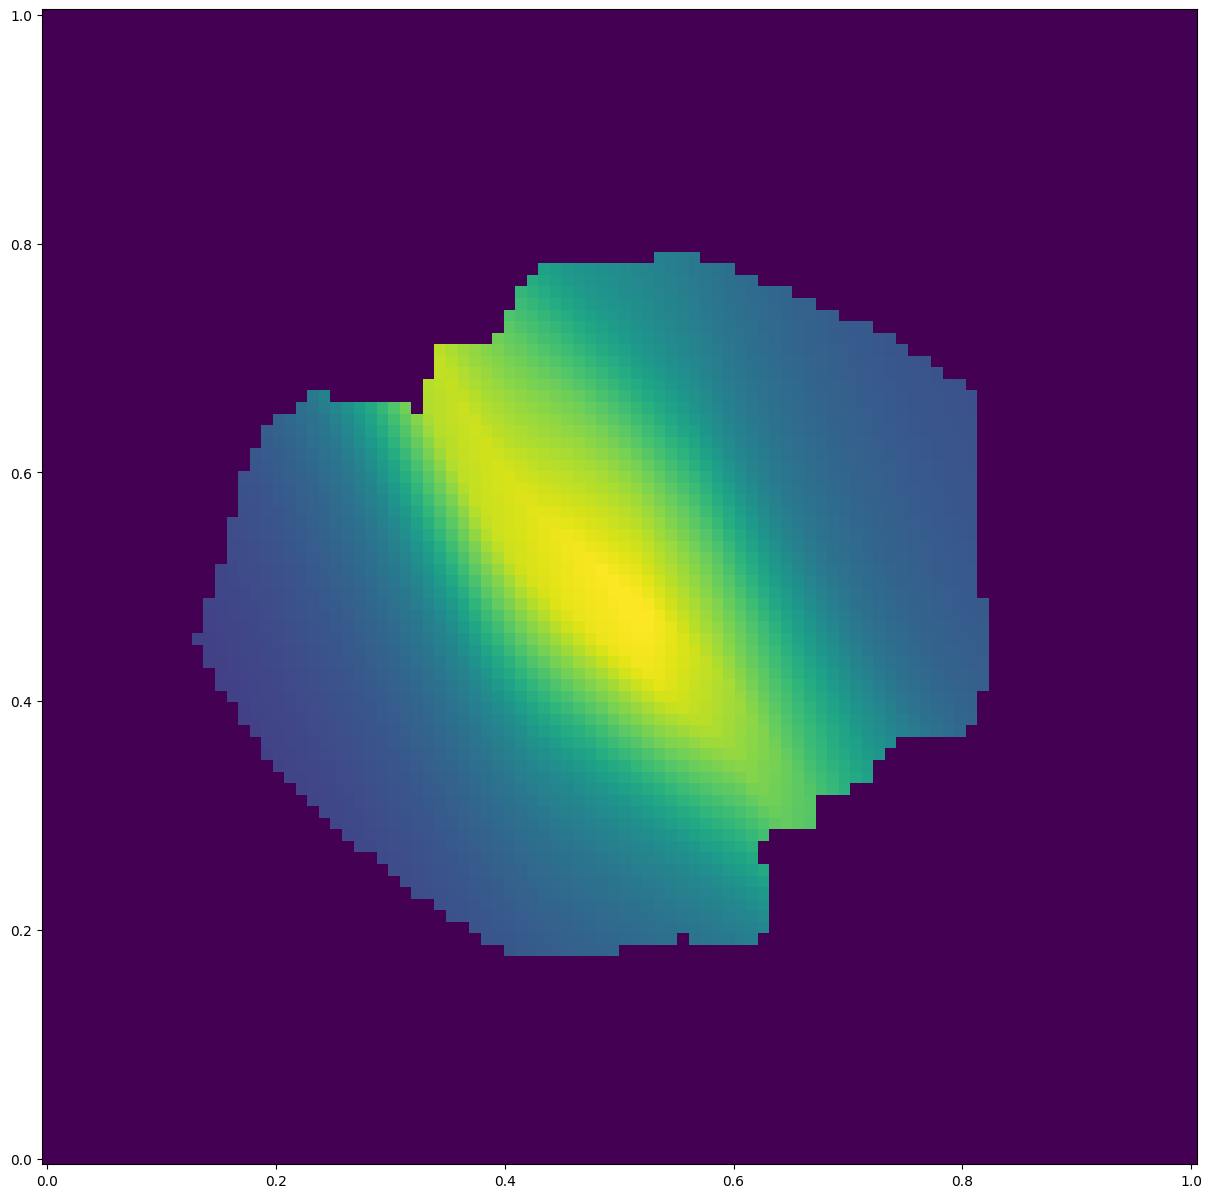

  8%|███▏                                    | 396/5000 [00:13<02:10, 35.35it/s]

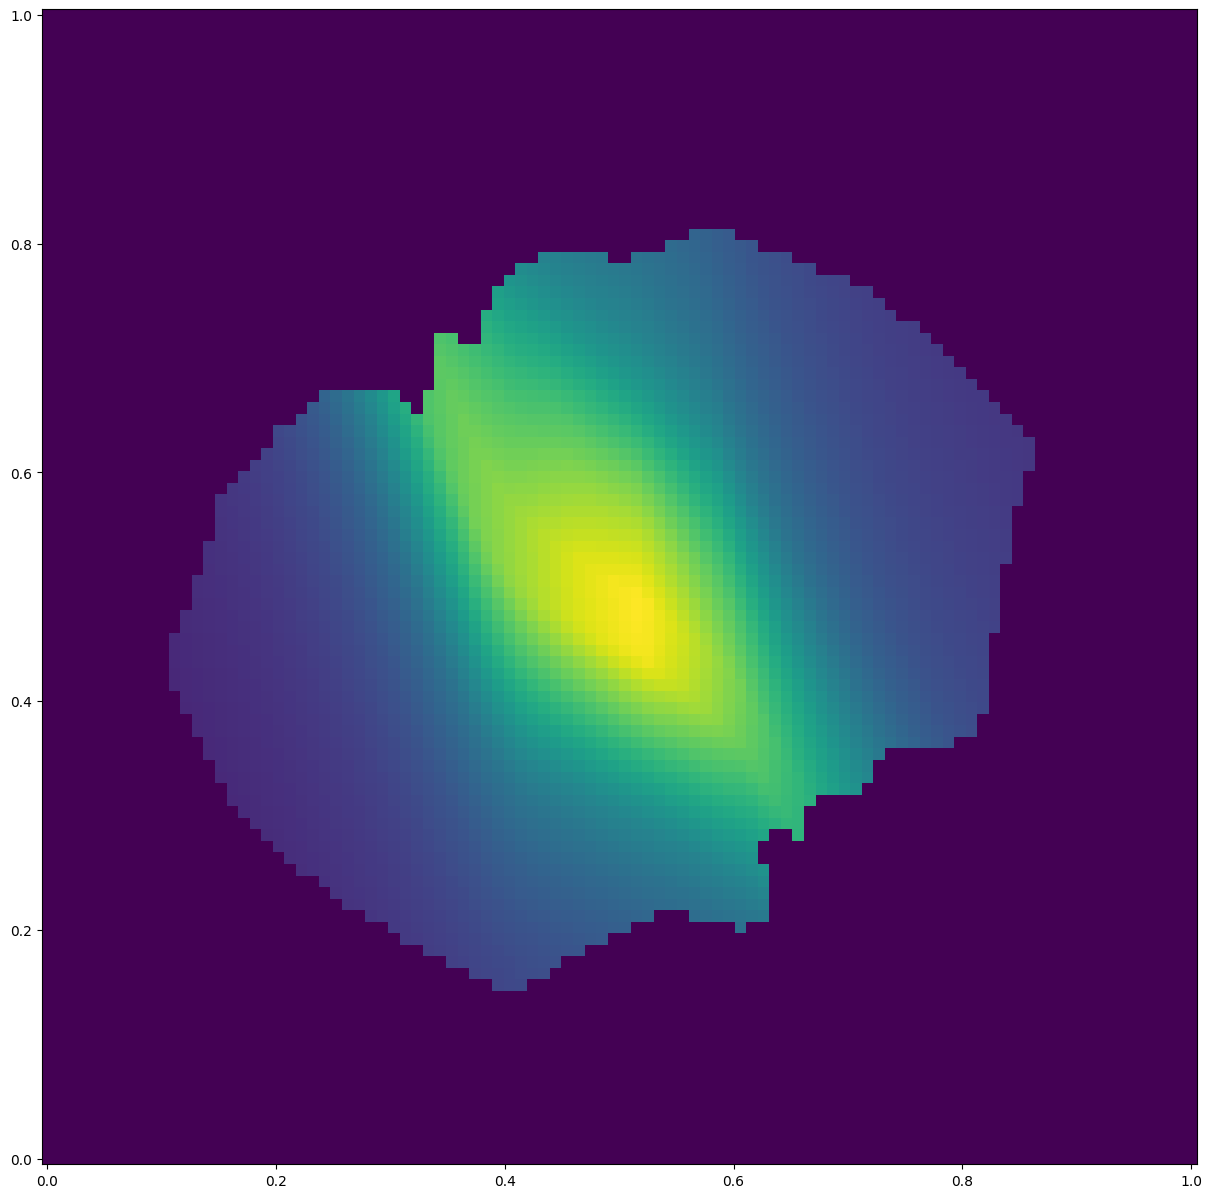

 10%|███▉                                    | 497/5000 [00:17<02:06, 35.59it/s]

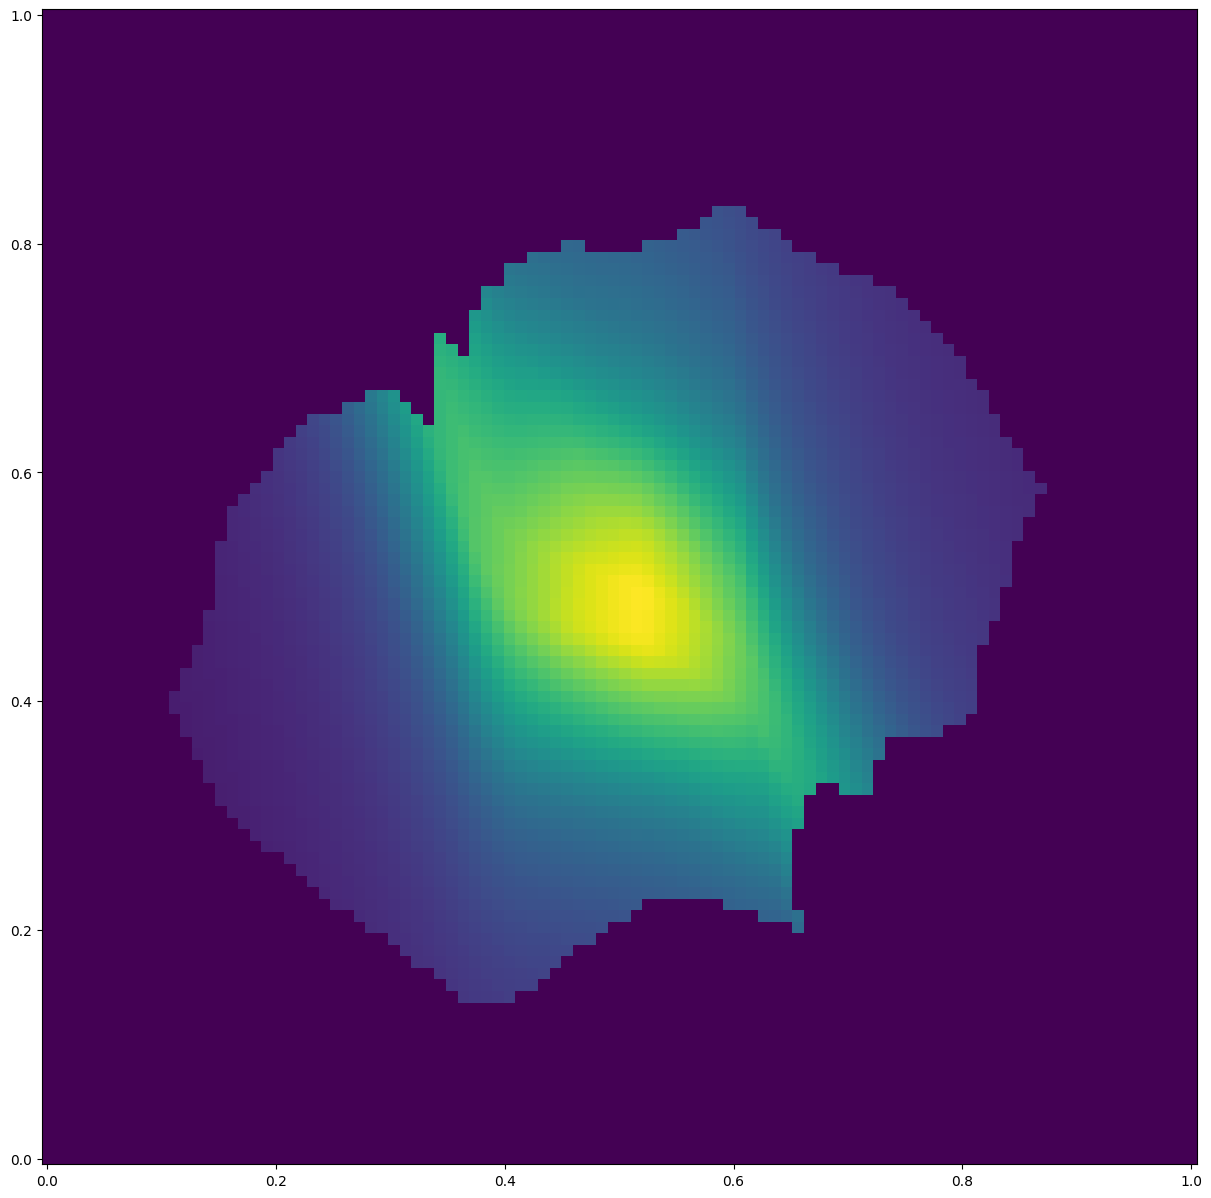

 12%|████▊                                   | 599/5000 [00:20<02:12, 33.13it/s]

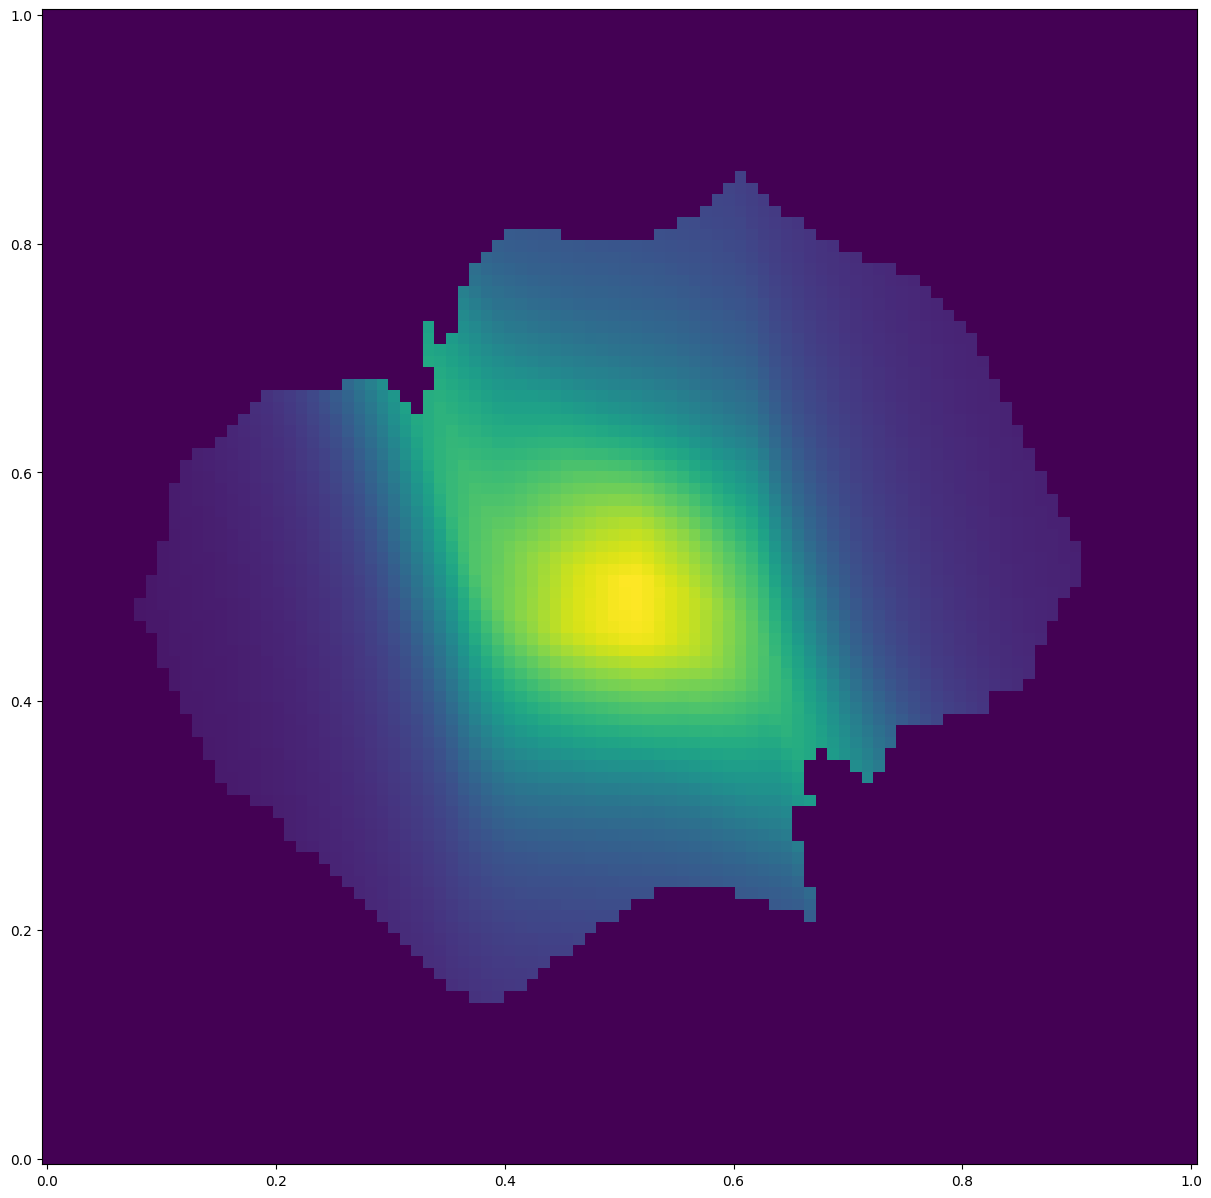

 14%|█████▌                                  | 698/5000 [00:24<02:50, 25.26it/s]

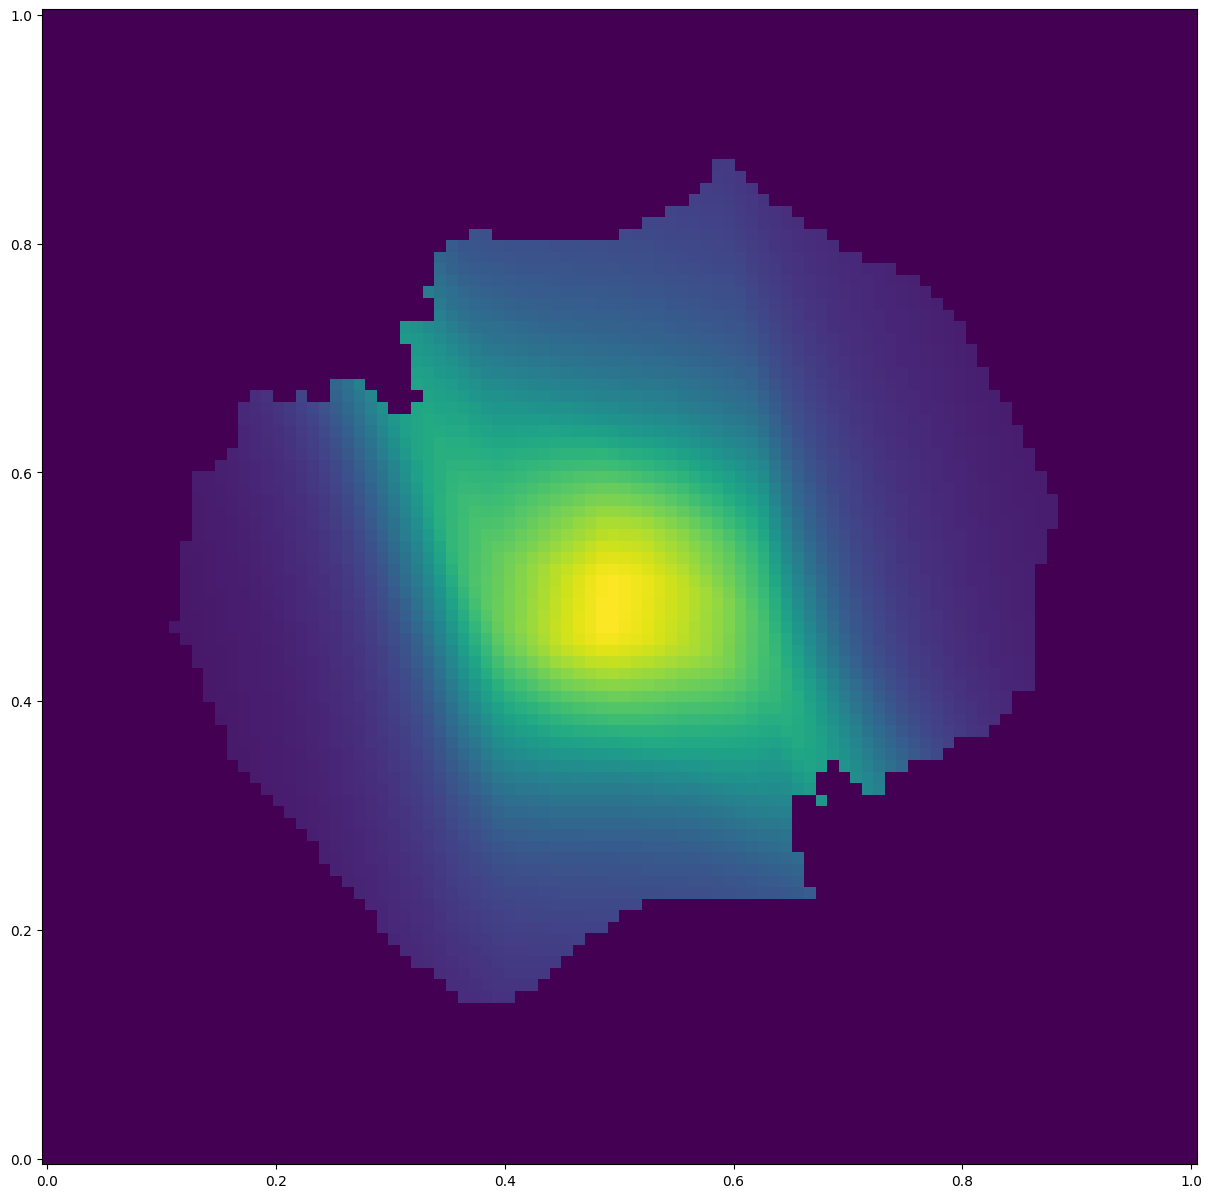

 16%|██████▎                                 | 784/5000 [00:28<02:31, 27.91it/s]


KeyboardInterrupt: 

In [91]:
# Train model
max_iter = 5000
num_samples = 1000
show_iter = 100
clip = 10.0

loss_hist = np.array([])

# proposal = lambda x: nfm.sample(x.shape[0])
# ms_sampler = nf.flows.MetropolisHastings(target, proposal ,100)
# z,_ = nfm.sample(num_samples)
# z,_ = ms_sampler.forward(z)
# ms_sampler.step = 5

optimizer = torch.optim.Adam(nfm.parameters(), lr=5e-4)#, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_iter)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
#     x_np, _ = make_moons(num_samples, noise=0.1)
#     x = torch.tensor(x_np).float().to(device)
    
    # Compute loss
#     if(it<max_iter/2):
#         loss = nfm.reverse_kld(num_samples)
#     else:

#     z,_ = ms_sampler.forward(z)
#     ms_sampler.proposal = lambda x: nfm.sample(x.shape[0])
#     #print(z)
#     loss = nfm.forward_kld(z.detach())
    #loss = nfm.MCvar(num_samples)
    
    #loss = nfm.reverse_kld(num_samples)#, beta=np.min([1., 0.001 + it / anneal_iter]))
    loss = nfm.IS_forward_kld(num_samples)
    #loss2 = nfm.IS_forward_kld(num_samples)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
#         if (it+1)%show_iter == 0:
#             #print(loss, loss2)
#             # make_dot(z, params=dict(nfm.named_parameters()))
#             for name, param in nfm.named_parameters():
#                 print(f"Gradient of {name} is \n{param.grad}")
        torch.nn.utils.clip_grad_value_(nfm.parameters(), clip)
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        nfm.eval()
        log_prob = nfm.log_prob(zz)
        nfm.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.gca().set_aspect('equal', 'box')
        plt.show()
    scheduler.step()


# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [ ]:
# Plot target distribution
# x_np, _ = make_moons(2 ** 20, noise=0.1)
# plt.figure(figsize=(15, 15))
# plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200)
# plt.show()

# Plot initial flow distribution
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(0.0, 1.0, grid_size), torch.linspace(0.0, 1.0, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

nfm.eval()
#log_prob = nfm.p.log_prob(zz).to('cpu').view(*xx.shape)
#prob = nfm.p.prob(zz).to('cpu').view(*xx.shape)
#prob = nfm.p.prob(zz).to('cpu').view(*xx.shape)
#print(prob, log_prob)
log_prob = nfm.q0.log_prob(zz).to('cpu').view(*xx.shape)
#print(prob)
#log_prob = log_prob - log_q
print(log_prob,log_q)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

In [ ]:
# Plot learned distribution
nfm.eval()
samples, logdetJ = nfm.sample(100000)
mean, variance = nfm.integrate_block(100000, 100)
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
nfm.train()

prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()
alpha = 0.2
ndims = 2
target_val = erf(1/(2.*alpha))**ndims
print(samples.shape, mean, variance, nfm.p.targetval)

In [ ]:
samples_np = samples.detach().numpy()
print(samples_np)
# Create a 2D histogram of the samples
hist, xedges, yedges = np.histogram2d(samples_np[:,0], samples_np[:,1], bins=50, density=True)

# Generate the x and y coordinates for the centers of the bins
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xcenters, ycenters)

# Plot the heatmap
plt.figure(figsize=(15, 15))
plt.pcolormesh(X, Y, hist, shading='auto')
plt.colorbar() # Show color scale
plt.gca().set_aspect('equal', 'box') # Keep aspect ratio square
plt.title('Sample Density Distribution Heatmap')
plt.show()